In [7]:
#API KEY
APIKey = 'sEIFGzgUrNYZ6r4X4BUViM7SInBspa48y07dhMIr'
print(len(APIKey))
#API Secret
APISecret = 'CgKdsiDHaGMdXv11c7XxJmReZazlNHI2uT-6dDDV'

40


In [6]:
import time
import urllib.parse
from typing import Optional, Dict, Any, List
from datetime import date 
from datetime import timedelta 
import datetime

from requests import Request, Session, Response
import hmac



class FtxClient:
    _ENDPOINT = 'https://ftx.com/api/'

    def __init__(self, api_key=None, api_secret=None, subaccount_name=None) -> None:
        self._session = Session()
        self._api_key = api_key
        self._api_secret = api_secret
        self._subaccount_name = subaccount_name

    def _get(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('GET', path, params=params)

    def _post(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('POST', path, json=params)

    def _delete(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('DELETE', path, json=params)

    def _request(self, method: str, path: str, **kwargs) -> Any:
        request = Request(method, self._ENDPOINT + path, **kwargs)
        self._sign_request(request)
        response = self._session.send(request.prepare())
        return self._process_response(response)

    def _sign_request(self, request: Request) -> None:
        ts = int(time.time() * 1000)
        prepared = request.prepare()
        signature_payload = f'{ts}{prepared.method}{prepared.path_url}'.encode()
        if prepared.body:
            signature_payload += prepared.body
        signature = hmac.new(self._api_secret.encode(), signature_payload, 'sha256').hexdigest()
        request.headers['FTX-KEY'] = self._api_key
        request.headers['FTX-SIGN'] = signature
        request.headers['FTX-TS'] = str(ts)
        if self._subaccount_name:
            request.headers['FTX-SUBACCOUNT'] = urllib.parse.quote(self._subaccount_name)

    def _process_response(self, response: Response) -> Any:
        try:
            data = response.json()
        except ValueError:
            response.raise_for_status()
            raise
        else:
            if not data['success']:
                raise Exception(data['error'])
            return data['result']

    def get_all_futures(self) -> List[dict]:
        return self._get('futures')

    def get_future(self, future_name: str = None) -> dict:
        return self._get(f'futures/{future_name}')

    def get_markets(self) -> List[dict]:
        return self._get('markets')

    def get_orderbook(self, market: str, depth: int = None) -> dict:
        return self._get(f'markets/{market}/orderbook', {'depth': depth})

    def get_trades(self, market: str, start_time: float = None, end_time: float = None) -> dict:
        return self._get(f'markets/{market}/trades', {'start_time': start_time, 'end_time': end_time})

    def get_account_info(self) -> dict:
        return self._get(f'account')

    def get_open_orders(self, market: str = None) -> List[dict]:
        return self._get(f'orders', {'market': market})

    def get_order_history(
        self, market: str = None, side: str = None, order_type: str = None,
        start_time: float = None, end_time: float = None
    ) -> List[dict]:
        return self._get(f'orders/history', {
            'market': market,
            'side': side,
            'orderType': order_type,
            'start_time': start_time,
            'end_time': end_time
        })

    def get_conditional_order_history(
        self, market: str = None, side: str = None, type: str = None,
        order_type: str = None, start_time: float = None, end_time: float = None
    ) -> List[dict]:
        return self._get(f'conditional_orders/history', {
            'market': market,
            'side': side,
            'type': type,
            'orderType': order_type,
            'start_time': start_time,
            'end_time': end_time
        })

    def modify_order(
        self, existing_order_id: Optional[str] = None,
        existing_client_order_id: Optional[str] = None, price: Optional[float] = None,
        size: Optional[float] = None, client_order_id: Optional[str] = None,
    ) -> dict:
        assert (existing_order_id is None) ^ (existing_client_order_id is None), \
            'Must supply exactly one ID for the order to modify'
        assert (price is None) or (size is None), 'Must modify price or size of order'
        path = f'orders/{existing_order_id}/modify' if existing_order_id is not None else \
            f'orders/by_client_id/{existing_client_order_id}/modify'
        return self._post(path, {
            **({'size': size} if size is not None else {}),
            **({'price': price} if price is not None else {}),
            ** ({'clientId': client_order_id} if client_order_id is not None else {}),
        })

    def get_conditional_orders(self, market: str = None) -> List[dict]:
        return self._get(f'conditional_orders', {'market': market})

    def place_order(self, market: str, side: str, price: float, size: float, type: str = 'limit',
                    reduce_only: bool = False, ioc: bool = False, post_only: bool = False,
                    client_id: str = None, reject_after_ts: float = None) -> dict:
        return self._post('orders', {
            'market': market,
            'side': side,
            'price': price,
            'size': size,
            'type': type,
            'reduceOnly': reduce_only,
            'ioc': ioc,
            'postOnly': post_only,
            'clientId': client_id,
            'rejectAfterTs': reject_after_ts
        })

    def place_conditional_order(
        self, market: str, side: str, size: float, type: str = 'stop',
        limit_price: float = None, reduce_only: bool = False, cancel: bool = True,
        trigger_price: float = None, trail_value: float = None
    ) -> dict:
        """
        To send a Stop Market order, set type='stop' and supply a trigger_price
        To send a Stop Limit order, also supply a limit_price
        To send a Take Profit Market order, set type='trailing_stop' and supply a trigger_price
        To send a Trailing Stop order, set type='trailing_stop' and supply a trail_value
        """
        assert type in ('stop', 'take_profit', 'trailing_stop')
        assert type not in ('stop', 'take_profit') or trigger_price is not None, \
            'Need trigger prices for stop losses and take profits'
        assert type not in ('trailing_stop',) or (trigger_price is None and trail_value is not None), \
            'Trailing stops need a trail value and cannot take a trigger price'

        return self._post('conditional_orders', {
            'market': market,
            'side': side,
            'triggerPrice': trigger_price,
            'size': size,
            'reduceOnly': reduce_only,
            'type': 'stop',
            'cancelLimitOnTrigger': cancel,
            'orderPrice': limit_price
        })

    def cancel_order(self, order_id: str) -> dict:
        return self._delete(f'orders/{order_id}')

    def cancel_orders(
        self, market_name: str = None,
        conditional_orders: bool = False, limit_orders: bool = False
    ) -> dict:
        return self._delete(f'orders', {
            'market': market_name,
            'conditionalOrdersOnly': conditional_orders,
            'limitOrdersOnly': limit_orders
        })

    def get_fills(self, market: str = None, start_time: float = None,
        end_time: float = None, min_id: int = None, order_id: int = None
    ) -> List[dict]:
        return self._get('fills', {
            'market': market,
            'start_time': start_time,
            'end_time': end_time,
            'minId': min_id,
            'orderId': order_id
        })

    def get_balances(self) -> List[dict]:
        return self._get('wallet/balances')

    def get_total_usd_balance(self) -> int:
        total_usd = 0
        balances = self._get('wallet/balances')
        for balance in balances:
            total_usd += balance['usdValue']
        return total_usd

    def get_all_balances(self) -> List[dict]:
        return self._get('wallet/all_balances')

    def get_total_account_usd_balance(self) -> int:
        total_usd = 0
        all_balances = self._get('wallet/all_balances')
        for wallet in all_balances:
            for balance in all_balances[wallet]:
                total_usd += balance['usdValue']
        return total_usd

    def get_positions(self, show_avg_price: bool = False) -> List[dict]:
        return self._get('positions', {'showAvgPrice': show_avg_price})

    def get_position(self, name: str, show_avg_price: bool = False) -> dict:
        return next(filter(lambda x: x['future'] == name, self.get_positions(show_avg_price)), None)

    # def get_all_trades(self, market: str, start_time: float = None, end_time: float = None) -> List:
    #     ids = set()
    #     limit = 100
    #     results = []
    #     while True:
    #         response = self._get(f'markets/{market}/trades', {
    #             'end_time': end_time,
    #             'start_time': start_time,
    #         })
    #         deduped_trades = [r for r in response if r['id'] not in ids]
    #         results.extend(deduped_trades)
    #         ids |= {r['id'] for r in deduped_trades}
    #         print(f'Adding {len(response)} trades with end time {end_time}')
    #         if len(response) == 0:
    #             break
    #         end_time = min(parse_datetime(t['time']) for t in response).timestamp()
    #         if len(response) < limit:
    #             break
    #     return results

    def get_historical_prices(
        self, market: str, resolution: int = 300, start_time: float = None,
        end_time: float = None
    ) -> List[dict]:
        return self._get(f'markets/{market}/candles', {
            'resolution': resolution,
            'start_time': start_time,
            'end_time': end_time
        })

    def get_last_historical_prices(self, market: str, resolution: int = 300) -> List[dict]:
        return self._get(f'markets/{market}/candles/last', {'resolution': resolution})

    def get_borrow_rates(self) -> List[dict]:
        return self._get('spot_margin/borrow_rates')

    def get_borrow_history(self, start_time: float = None, end_time: float = None) -> List[dict]:
        return self._get('spot_margin/borrow_history', {'start_time': start_time, 'end_time': end_time})

    def get_lending_history(self, start_time: float = None, end_time: float = None) -> List[dict]:
        return self._get('spot_margin/lending_history', {
            'start_time': start_time,
            'end_time': end_time
        })

    def get_expired_futures(self) -> List[dict]:
        return self._get('expired_futures')

    def get_coins(self) -> List[dict]:
        return self._get('wallet/coins')

    def get_future_stats(self, future_name: str) -> dict:
        return self._get(f'futures/{future_name}/stats')

    def get_single_market(self, market: str = None) -> Dict:
        return self._get(f'markets/{market}')

    def get_market_info(self, market: str = None) -> dict:
        return self._get('spot_margin/market_info', {'market': market})

    def get_trigger_order_triggers(self, conditional_order_id: str = None) -> List[dict]:
        return self._get(f'conditional_orders/{conditional_order_id}/triggers')

    def get_trigger_order_history(self, market: str = None) -> List[dict]:
        return self._get('conditional_orders/history', {'market': market})

    def get_staking_balances(self) -> List[dict]:
        return self._get('staking/balances')

    def get_stakes(self) -> List[dict]:
        return self._get('staking/stakes')

    def get_staking_rewards(self, start_time: float = None, end_time: float = None) -> List[dict]:
        return self._get('staking/staking_rewards', {
            'start_time': start_time,
            'end_time': end_time
        })

    def place_staking_request(self, coin: str = 'SRM', size: float = None) -> dict:
        return self._post('srm_stakes/stakes',)

    def get_funding_rates(self, future: str = None, start_time: float = None, end_time: float = None)-> List[dict]:
        return self._get('funding_rates', {
            'future': future,
            'start_time': start_time,
            'end_time': end_time
        })

    def get_all_funding_rates(self) -> List[dict]:
        return self._get('funding_rates')

    def get_funding_payments(self, start_time: float = None, end_time: float = None) -> List[dict]:
        return self._get('funding_payments', {
            'start_time': start_time,
            'end_time': end_time
        })

    def create_subaccount(self, nickname: str) -> dict:
        return self._post('subaccounts', {'nickname': nickname})

    def get_subaccount_balances(self, nickname: str) -> List[dict]:
        return self._get(f'subaccounts/{nickname}/balances')

    def get_deposit_address(self, ticker: str) -> dict:
        return self._get(f'wallet/deposit_address/{ticker}')

    def get_deposit_history(self) -> List[dict]:
        return self._get('wallet/deposits')

    def get_total_eur_deposit(self):
        t=0.0
        for i in self.get_deposit_history():
            if (i['coin'] == 'EUR') & (i['status']=='complete'):
                t+=i['size']
        return t

    def get_withdrawal_fee(self, coin: str, size: int, address: str, method: str = None, tag: str = None) -> Dict:
        return self._get('wallet/withdrawal_fee', {
            'coin': coin,
            'size': size,
            'address': address,
            'method': method,
            'tag': tag
        })
    
    def get_all_subaccount(self):
        return self._get(f'subaccounts')

    def get_withdrawals(self, start_time: float = None, end_time: float = None) -> List[dict]:
        return self._get('wallet/withdrawals', {'start_time': start_time, 'end_time': end_time})

    def get_saved_addresses(self, coin: str = None) -> dict:
        return self._get('wallet/saved_addresses', {'coin': coin})

    def submit_fiat_withdrawal(self, coin: str, size: int, saved_address_id: int, code: int = None) -> Dict:
        return self._post('wallet/fiat_withdrawals', {
        'coin': coin,
        'size': size,
        'savedAddressId': saved_address_id,
        'code': code
    })

    def get_latency_stats(self, days: int = 1, subaccount_nickname: str = None) -> Dict:
        return self._get('stats/latency_stats', {'days': days, 'subaccount_nickname': subaccount_nickname})

    def get_biggest_balance(self):
        allBall = self.get_balances()
        maxValue=0
        index=0
        i=0
        for coin in allBall:
            if coin['usdValue']>maxValue:
                maxValue=coin['usdValue']
                index=i
            i+=1
        return allBall[index]

    def get_smallest_balance(self):
        allBall = self.get_balances()
        minValue=0
        index=0
        i=0
        for coin in allBall:
            if coin['usdValue']<minValue:
                minValue=coin['usdValue']
                index=i
            i+=1
        return allBall[index]

    def get_historical_balance(self):
        return self._get(f'historical_balances/requests')

    def get_historical_balance_id_main(self,id):
        req = 'historical_balances/requests/'+str(id)
        return self._get(req)

    def post_yesterday_historical_balance(self):
        yest = date.today()  - timedelta(days = 1)
        timeSt = time.mktime(datetime.datetime.strptime(str(yest), "%Y-%m-%d").timetuple())
        try : 
            id = self._post('historical_balances/requests',{"accounts": ["main"],
            "endTime": timeSt})
        except:
            time.sleep(1)
            self.post_yesterday_historical_balance()
        return id

    def post_historical_balance(self,date):
        timeSt = time.mktime(datetime.datetime.strptime(str(date), "%Y-%m-%d").timetuple())
        try : 
            id = self._post('historical_balances/requests',{"accounts": ["main"],
            "endTime": timeSt})
        except:
            self.post_historical_balance()
        return id



        

ts = int(time.time() * 1000)
request = Request('GET', 'https://ftx.com/api/wallet/all_balances')
prepared = request.prepare()
signature_payload = f'{ts}{prepared.method}{prepared.path_url}'.encode()
signature = hmac.new(APISecret.encode(), signature_payload, 'sha256').hexdigest()

prepared.headers['FTX-KEY'] = APIKey
prepared.headers['FTX-SIGN'] = signature
prepared.headers['FTX-TS'] = str(ts)

In [8]:
account = FtxClient(APIKey,APISecret)

In [10]:
from currency_converter import CurrencyConverter
c = CurrencyConverter()

usdBalance = round(account.get_total_usd_balance(),2)
print(usdBalance)
round(c.convert(usdBalance,'USD','EUR'),2)

844.16


768.12

In [22]:

account.get_historical_balance()

[{'id': 26585,
  'accounts': ['main'],
  'time': '2022-04-10T16:00:34.519370+00:00',
  'endTime': '2022-04-08T22:00:00+00:00',
  'status': 'done',
  'error': False,
  'results': [{'account': 'main', 'ticker': 'BTC', 'size': 0.00363212},
   {'account': 'main', 'ticker': 'USDT', 'size': 0.23455745},
   {'account': 'main', 'ticker': 'ETH', 'size': 0.03618669},
   {'account': 'main', 'ticker': 'XRP', 'size': 495.47887927},
   {'account': 'main', 'ticker': 'EUR', 'size': 1.57092614e-08},
   {'account': 'main', 'ticker': 'SOL', 'size': 0.23426234},
   {'account': 'main', 'ticker': 'MANA', 'size': 24.41622043},
   {'account': 'main', 'ticker': 'AVAX', 'size': 0.72832547}]},
 {'id': 26511,
  'accounts': ['main'],
  'time': '2022-04-09T22:38:44.623771+00:00',
  'endTime': '2022-04-08T22:00:00+00:00',
  'status': 'done',
  'error': False,
  'results': [{'account': 'main', 'ticker': 'BTC', 'size': 0.00363212},
   {'account': 'main', 'ticker': 'USDT', 'size': 0.23455745},
   {'account': 'main', 't

In [5]:
account.post_yesterday_historical_balance()

26585

In [6]:
account.get_historical_balance_id_main(26511)

{'id': 26511,
 'accounts': ['main'],
 'time': '2022-04-09T22:38:44.623771+00:00',
 'endTime': '2022-04-08T22:00:00+00:00',
 'status': 'done',
 'error': False,
 'results': [{'account': 'main', 'ticker': 'BTC', 'size': 0.00363212},
  {'account': 'main', 'ticker': 'USDT', 'size': 0.23455745},
  {'account': 'main', 'ticker': 'ETH', 'size': 0.03618669},
  {'account': 'main', 'ticker': 'XRP', 'size': 495.47887927},
  {'account': 'main', 'ticker': 'EUR', 'size': 1.57092614e-08},
  {'account': 'main', 'ticker': 'SOL', 'size': 0.23426234},
  {'account': 'main', 'ticker': 'MANA', 'size': 24.41622043},
  {'account': 'main', 'ticker': 'AVAX', 'size': 0.72832547}]}

In [23]:
yest = date.today()  - timedelta(days = 2)
str(yest)

'2022-04-08'

In [24]:

def get_FTX_historical_balance_id_yesterday():
    response = account.get_historical_balance()
    yest = date.today()  - timedelta(days = 2)
    for i in response:
        if i['endTime'][:10]==str(yest):
            return i['id']
    account.post_yesterday_historical_balance()
    get_FTX_historical_balance_id_yesterday()

def get_FTX_historical_balance(id):
    response = account.get_historical_balance_id_main(id)
    count = 120
    if (len(response['results'])==0) and (count!=0):
        response = account.get_historical_balance_id_main(id)
        count-=1
        time.sleep(0.5)
    else :
        return response

z=get_FTX_historical_balance_id_yesterday()
a=get_FTX_historical_balance(z)
a

{'id': 26585,
 'accounts': ['main'],
 'time': '2022-04-10T16:00:34.519370+00:00',
 'endTime': '2022-04-08T22:00:00+00:00',
 'status': 'done',
 'error': False,
 'results': [{'account': 'main', 'ticker': 'BTC', 'size': 0.00363212},
  {'account': 'main', 'ticker': 'USDT', 'size': 0.23455745},
  {'account': 'main', 'ticker': 'ETH', 'size': 0.03618669},
  {'account': 'main', 'ticker': 'XRP', 'size': 495.47887927},
  {'account': 'main', 'ticker': 'EUR', 'size': 1.57092614e-08},
  {'account': 'main', 'ticker': 'SOL', 'size': 0.23426234},
  {'account': 'main', 'ticker': 'MANA', 'size': 24.41622043},
  {'account': 'main', 'ticker': 'AVAX', 'size': 0.72832547}]}

In [25]:
account.get_markets()

[{'name': '1INCH-PERP',
  'enabled': True,
  'postOnly': False,
  'priceIncrement': 0.0001,
  'sizeIncrement': 1.0,
  'minProvideSize': 1.0,
  'last': 1.6152,
  'bid': 1.615,
  'ask': 1.6155,
  'price': 1.6152,
  'type': 'future',
  'baseCurrency': None,
  'quoteCurrency': None,
  'underlying': '1INCH',
  'restricted': False,
  'highLeverageFeeExempt': False,
  'largeOrderThreshold': 500.0,
  'change1h': 0.0008675176601809394,
  'change24h': -0.00895815437476991,
  'changeBod': -0.023812401788952012,
  'quoteVolume24h': 5410104.5485,
  'volumeUsd24h': 5410104.5485,
  'priceHigh24h': 1.6707,
  'priceLow24h': 1.5972},
 {'name': '1INCH-0624',
  'enabled': True,
  'postOnly': False,
  'priceIncrement': 0.0001,
  'sizeIncrement': 1.0,
  'minProvideSize': 1.0,
  'last': 1.5748,
  'bid': 1.5743,
  'ask': 1.5756,
  'price': 1.5748,
  'type': 'future',
  'baseCurrency': None,
  'quoteCurrency': None,
  'underlying': '1INCH',
  'restricted': False,
  'highLeverageFeeExempt': False,
  'largeOrder

In [ ]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Activation, Dense, Dropout, GRU
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [2]:
import json
import requests


def func_args_preprocessing(func):
    """Return function that converts list input arguments to comma-separated strings"""

    def input_args(*args, **kwargs):

        # check in **kwargs for lists and booleans
        for v in kwargs:
            kwargs[v] = arg_preprocessing(kwargs[v])
        # check in *args for lists and booleans
        args = [arg_preprocessing(v) for v in args]

        return func(*args, **kwargs)

    return input_args

def arg_preprocessing(arg_v):
    """Return the values of an argument after preprocessing"""

    # check if arg is list and convert it to comma-separated string
    if isinstance(arg_v, list):
        arg_v = ','.join(arg_v)
    # check if arg is boolean and convert it to string
    elif isinstance(arg_v, bool):
        arg_v = str(arg_v).lower()

    return arg_v


class CoinGeckoAPI:
    __API_URL_BASE = 'https://api.coingecko.com/api/v3/'

    def __init__(self, api_base_url=__API_URL_BASE):
        self.api_base_url = api_base_url
        self.request_timeout = 120

        self.session = requests.Session()

    def __request(self, url):
        # print(url)
        try:
            response = self.session.get(url, timeout=self.request_timeout)
        except requests.exceptions.RequestException:
            raise

        try:
            response.raise_for_status()
            content = json.loads(response.content.decode('utf-8'))
            return content
        except Exception as e:
            # check if json (with error message) is returned
            try:
                content = json.loads(response.content.decode('utf-8'))
                raise ValueError(content)
            # if no json
            except json.decoder.JSONDecodeError:
                pass

            raise

    def __api_url_params(self, api_url, params, api_url_has_params=False):
        if params:
            # if api_url contains already params and there is already a '?' avoid
            # adding second '?' (api_url += '&' if '?' in api_url else '?'); causes
            # issues with request parametes (usually for endpoints with required
            # arguments passed as parameters)
            api_url += '&' if api_url_has_params else '?'
            for key, value in params.items():
                if type(value) == bool:
                    value = str(value).lower()

                api_url += "{0}={1}&".format(key, value)
            api_url = api_url[:-1]
        return api_url

    # ---------- PING ----------#
    def ping(self):
        """Check API server status"""

        api_url = '{0}ping'.format(self.api_base_url)
        return self.__request(api_url)

    # ---------- SIMPLE ----------#
    @func_args_preprocessing
    def get_price(self, ids, vs_currencies, **kwargs):
        """Get the current price of any cryptocurrencies in any other supported currencies that you need"""

        ids = ids.replace(' ', '')
        kwargs['ids'] = ids
        vs_currencies = vs_currencies.replace(' ', '')
        kwargs['vs_currencies'] = vs_currencies

        api_url = '{0}simple/price'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_token_price(self, id, contract_addresses, vs_currencies, **kwargs):
        """Get the current price of any tokens on this coin (ETH only at this stage as per api docs) in any other supported currencies that you need"""

        contract_addresses = contract_addresses.replace(' ', '')
        kwargs['contract_addresses'] = contract_addresses
        vs_currencies = vs_currencies.replace(' ', '')
        kwargs['vs_currencies'] = vs_currencies

        api_url = '{0}simple/token_price/{1}'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)
        return self.__request(api_url)

    @func_args_preprocessing
    def get_supported_vs_currencies(self, **kwargs):
        """Get list of supported_vs_currencies"""

        api_url = '{0}simple/supported_vs_currencies'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- COINS ----------#
    @func_args_preprocessing
    def get_coins(self, **kwargs):
        """List all coins with data (name, price, market, developer, community, etc)"""

        api_url = '{0}coins'.format(self.api_base_url)
        # ['order', 'per_page', 'page', 'localization']
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coins_list(self, **kwargs):
        """List all supported coins id, name and symbol (no pagination required)"""

        api_url = '{0}coins/list'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coins_markets(self, vs_currency, **kwargs):
        """List all supported coins price, market cap, volume, and market related data"""

        kwargs['vs_currency'] = vs_currency

        api_url = '{0}coins/markets'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coin_by_id(self, id, **kwargs):
        """Get current data (name, price, market, ... including exchange tickers) for a coin"""

        api_url = '{0}coins/{1}/'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coin_ticker_by_id(self, id, **kwargs):
        """Get coin tickers (paginated to 100 items)"""

        api_url = '{0}coins/{1}/tickers'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coin_history_by_id(self, id, date, **kwargs):
        """Get historical data (name, price, market, stats) at a given date for a coin"""

        kwargs['date'] = date

        api_url = '{0}coins/{1}/history'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coin_market_chart_by_id(self, id, vs_currency, days,interval, **kwargs):
        """Get historical market data include price, market cap, and 24h volume (granularity auto)"""

        api_url = '{0}coins/{1}/market_chart?vs_currency={2}&days={3}&interval={4}'.format(self.api_base_url, id, vs_currency, days,interval)
        api_url = self.__api_url_params(api_url, kwargs, api_url_has_params=True)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coin_market_chart_range_by_id(self, id, vs_currency, from_timestamp, to_timestamp, **kwargs):
        """Get historical market data include price, market cap, and 24h volume within a range of timestamp (granularity auto)"""

        api_url = '{0}coins/{1}/market_chart/range?vs_currency={2}&from={3}&to={4}'.format(self.api_base_url, id,
                                                                                           vs_currency, from_timestamp,
                                                                                           to_timestamp)
        api_url = self.__api_url_params(api_url, kwargs, api_url_has_params=True)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coin_status_updates_by_id(self, id, **kwargs):
        """Get status updates for a given coin"""

        api_url = '{0}coins/{1}/status_updates'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coin_ohlc_by_id(self, id, vs_currency, days, **kwargs):
        """Get coin's OHLC"""

        api_url = '{0}coins/{1}/ohlc?vs_currency={2}&days={3}'.format(self.api_base_url, id, vs_currency, days)
        api_url = self.__api_url_params(api_url, kwargs, api_url_has_params=True)

        return self.__request(api_url)

    # ---------- Contract ----------#
    @func_args_preprocessing
    def get_coin_info_from_contract_address_by_id(self, id, contract_address, **kwargs):
        """Get coin info from contract address"""

        api_url = '{0}coins/{1}/contract/{2}'.format(self.api_base_url, id, contract_address)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coin_market_chart_from_contract_address_by_id(self, id, contract_address, vs_currency, days, **kwargs):
        """Get historical market data include price, market cap, and 24h volume (granularity auto) from a contract address"""

        api_url = '{0}coins/{1}/contract/{2}/market_chart/?vs_currency={3}&days={4}'.format(self.api_base_url, id,
                                                                                            contract_address,
                                                                                            vs_currency, days)
        api_url = self.__api_url_params(api_url, kwargs, api_url_has_params=True)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coin_market_chart_range_from_contract_address_by_id(self, id, contract_address, vs_currency, from_timestamp,
                                                                to_timestamp, **kwargs):
        """Get historical market data include price, market cap, and 24h volume within a range of timestamp (granularity auto) from a contract address"""

        api_url = '{0}coins/{1}/contract/{2}/market_chart/range?vs_currency={3}&from={4}&to={5}'.format(
            self.api_base_url, id, contract_address, vs_currency, from_timestamp, to_timestamp)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- ASSET PLATFORMS ----------#
    @func_args_preprocessing
    def get_asset_platforms(self, **kwargs):
        """List all asset platforms (Blockchain networks)"""

        api_url = '{0}asset_platforms'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- CATEGORIES ----------#
    @func_args_preprocessing
    def get_coins_categories_list(self, **kwargs):
        """List all categories"""

        api_url = '{0}coins/categories/list'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_coins_categories(self, **kwargs):
        """List all categories with market data"""

        api_url = '{0}coins/categories'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- EXCHANGES ----------#
    @func_args_preprocessing
    def get_exchanges_list(self, **kwargs):
        """List all exchanges"""

        api_url = '{0}exchanges'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_exchanges_id_name_list(self, **kwargs):
        """List all supported markets id and name (no pagination required)"""

        api_url = '{0}exchanges/list'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_exchanges_by_id(self, id, **kwargs):
        """Get exchange volume in BTC and tickers"""

        api_url = '{0}exchanges/{1}'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_exchanges_tickers_by_id(self, id, **kwargs):
        """Get exchange tickers (paginated, 100 tickers per page)"""

        api_url = '{0}exchanges/{1}/tickers'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_exchanges_status_updates_by_id(self, id, **kwargs):
        """Get status updates for a given exchange"""

        api_url = '{0}exchanges/{1}/status_updates'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_exchanges_volume_chart_by_id(self, id, days, **kwargs):
        """Get volume chart data for a given exchange"""

        kwargs['days'] = days

        api_url = '{0}exchanges/{1}/volume_chart'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- FINANCE ----------#
    @func_args_preprocessing
    def get_finance_platforms(self, **kwargs):
        """Get cryptocurrency finance platforms data"""

        api_url = '{0}finance_platforms'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_finance_products(self, **kwargs):
        """Get cryptocurrency finance products data"""

        api_url = '{0}finance_products'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- INDEXES ----------#
    @func_args_preprocessing
    def get_indexes(self, **kwargs):
        """List all market indexes"""

        api_url = '{0}indexes'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # @func_args_preprocessing
    # def get_indexes_by_id(self, id, **kwargs):
    #    """Get market index by id"""
    #
    #    api_url = '{0}indexes/{1}'.format(self.api_base_url, id)
    #    api_url = self.__api_url_params(api_url, kwargs)
    #
    #    return self.__request(api_url)

    @func_args_preprocessing
    def get_indexes_by_market_id_and_index_id(self, market_id, id, **kwargs):
        """Get market index by market id and index id"""

        api_url = '{0}indexes/{1}/{2}'.format(self.api_base_url, market_id, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_indexes_list(self, **kwargs):
        """List market indexes id and name"""

        api_url = '{0}indexes/list'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- DERIVATIVES ----------#
    @func_args_preprocessing
    def get_derivatives(self, **kwargs):
        """List all derivative tickers"""

        api_url = '{0}derivatives'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_derivatives_exchanges(self, **kwargs):
        """List all derivative tickers"""

        api_url = '{0}derivatives/exchanges'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_derivatives_exchanges_by_id(self, id, **kwargs):
        """List all derivative tickers"""

        api_url = '{0}derivatives/exchanges/{1}'.format(self.api_base_url, id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_derivatives_exchanges_list(self, **kwargs):
        """List all derivative tickers"""

        api_url = '{0}derivatives/exchanges/list'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- STATUS UPDATES ----------#
    @func_args_preprocessing
    def get_status_updates(self, **kwargs):
        """List all status_updates with data (description, category, created_at, user, user_title and pin)"""

        api_url = '{0}status_updates'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- EVENTS ----------#
    @func_args_preprocessing
    def get_events(self, **kwargs):
        """Get events, paginated by 100"""

        api_url = '{0}events'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_events_countries(self, **kwargs):
        """Get list of event countries"""

        api_url = '{0}events/countries'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    @func_args_preprocessing
    def get_events_types(self, **kwargs):
        """Get list of event types"""

        api_url = '{0}events/types'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- EXCHANGE-RATES ----------#
    @func_args_preprocessing
    def get_exchange_rates(self, **kwargs):
        """Get BTC-to-Currency exchange rates"""

        api_url = '{0}exchange_rates'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- TRENDING ----------#
    @func_args_preprocessing
    def get_search_trending(self, **kwargs):
        """Get top 7 trending coin searches"""

        api_url = '{0}search/trending'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

    # ---------- GLOBAL ----------#
    @func_args_preprocessing
    def get_global(self, **kwargs):
        """Get cryptocurrency global data"""

        api_url = '{0}global'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)['data']

    @func_args_preprocessing
    def get_global_decentralized_finance_defi(self, **kwargs):
        """Get cryptocurrency global decentralized finance(defi) data"""

        api_url = '{0}global/decentralized_finance_defi'.format(self.api_base_url)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)['data']

    # ---------- COMPANIES ----------#
    @func_args_preprocessing
    def get_companies_public_treasury_by_coin_id(self, coin_id, **kwargs):
        """Get public companies data"""

        api_url = '{0}companies/public_treasury/{1}'.format(self.api_base_url, coin_id)
        api_url = self.__api_url_params(api_url, kwargs)

        return self.__request(api_url)

In [3]:
import pandas as pd
from datetime import datetime
cg = CoinGeckoAPI()

In [39]:
cg = CoinGeckoAPI()
req=cg.get_coins()
req

[{'id': 'bitcoin',
  'symbol': 'btc',
  'name': 'Bitcoin',
  'block_time_in_minutes': '10.0',
  'image': {'thumb': 'https://assets.coingecko.com/coins/images/1/thumb/bitcoin.png?1547033579',
   'small': 'https://assets.coingecko.com/coins/images/1/small/bitcoin.png?1547033579',
   'large': 'https://assets.coingecko.com/coins/images/1/large/bitcoin.png?1547033579'},
  'market_data': {'current_price': {'aed': 144197,
    'ars': 4522265,
    'aud': 54874,
    'bch': 129.477,
    'bdt': 3389209,
    'bhd': 14798.97,
    'bmd': 39258,
    'bnb': 97.971,
    'brl': 193894,
    'btc': 1.0,
    'cad': 50027,
    'chf': 38042,
    'clp': 33698215,
    'cny': 258649,
    'czk': 911536,
    'dkk': 276294,
    'dot': 2367,
    'eos': 17121,
    'eth': 13.571958,
    'eur': 37127,
    'gbp': 31241,
    'hkd': 308089,
    'huf': 14000147,
    'idr': 568991256,
    'ils': 130468,
    'inr': 2998367,
    'jpy': 5119066,
    'krw': 49429956,
    'kwd': 12036.17,
    'lkr': 13717663,
    'ltc': 386.492,

In [43]:
req=cg.get_coin_by_id('ripple')
req

{'id': 'ripple',
 'symbol': 'xrp',
 'name': 'XRP',
 'asset_platform_id': None,
 'platforms': {'': ''},
 'block_time_in_minutes': 0,
 'hashing_algorithm': None,
 'categories': ['Cryptocurrency'],
 'public_notice': None,
 'additional_notices': [],
 'localization': {'en': 'XRP',
  'de': 'XRP',
  'es': 'XRP',
  'fr': 'XRP',
  'it': 'XRP',
  'pl': 'XRP',
  'ro': 'XRP',
  'hu': 'XRP',
  'nl': 'XRP',
  'pt': 'XRP',
  'sv': 'XRP',
  'vi': 'XRP',
  'tr': 'XRP',
  'ru': 'Ripple',
  'ja': 'リップル',
  'zh': '瑞波币',
  'zh-tw': '瑞波幣',
  'ko': '리플코인',
  'ar': 'XRP',
  'th': 'XRP',
  'id': 'XRP',
  'cs': 'XRP',
  'da': 'XRP',
  'el': 'XRP',
  'hi': 'XRP',
  'no': 'XRP',
  'sk': 'XRP',
  'uk': 'XRP',
  'he': 'XRP',
  'fi': 'XRP',
  'bg': 'XRP',
  'hr': 'XRP',
  'lt': 'XRP',
  'sl': 'XRP'},
 'description': {'en': 'Ripple is the catchall name for the cryptocurrency platform, the transactional protocol for which is actually XRP, in the same fashion as <a href="https://www.coingecko.com/en/coins/ethereum">Eth

In [38]:
keys=[]
for key in req['market_data']['current_price']:
    keys.append(key)
keys

['aed',
 'ars',
 'aud',
 'bch',
 'bdt',
 'bhd',
 'bmd',
 'bnb',
 'brl',
 'btc',
 'cad',
 'chf',
 'clp',
 'cny',
 'czk',
 'dkk',
 'dot',
 'eos',
 'eth',
 'eur',
 'gbp',
 'hkd',
 'huf',
 'idr',
 'ils',
 'inr',
 'jpy',
 'krw',
 'kwd',
 'lkr',
 'ltc',
 'mmk',
 'mxn',
 'myr',
 'ngn',
 'nok',
 'nzd',
 'php',
 'pkr',
 'pln',
 'rub',
 'sar',
 'sek',
 'sgd',
 'thb',
 'try',
 'twd',
 'uah',
 'usd',
 'vef',
 'vnd',
 'xag',
 'xau',
 'xdr',
 'xlm',
 'xrp',
 'yfi',
 'zar',
 'bits',
 'link',
 'sats']

In [4]:
cg = CoinGeckoAPI()
req=cg.get_coin_market_chart_by_id(id='bitcoin', vs_currency='usd', days=1000, interval='daily')
for i in range(len(req['prices'])):
    req['prices'][i][0]=datetime.fromtimestamp(int(str(req['prices'][i][0])[:-3]))

prices = []
dates = []
volume = []
marketcap = []
for i in range(len(req['prices'])):
    prices.append(req['prices'][i][1])
    dates.append(req['prices'][i][0])
    volume.append(req['total_volumes'][i][1])
    marketcap.append(req['market_caps'][i][1])

In [6]:
prices=cg.get_coin_market_chart_by_id(id='bitcoin', vs_currency='usd', days=1000, interval='daily')
prices

{'prices': [[1564876800000, 10791.200523159],
  [1564963200000, 10951.593834840049],
  [1565049600000, 11818.525531066103],
  [1565136000000, 11510.164154730011],
  [1565222400000, 11970.657556451994],
  [1565308800000, 12024.331570998236],
  [1565395200000, 11852.561606995518],
  [1565481600000, 11327.842642233223],
  [1565568000000, 11549.998354322472],
  [1565654400000, 11381.241355678554],
  [1565740800000, 10903.6549918801],
  [1565827200000, 10016.217389275296],
  [1565913600000, 10295.87714290961],
  [1566000000000, 10324.993597415598],
  [1566086400000, 10224.218706633936],
  [1566172800000, 10309.872435928555],
  [1566259200000, 10895.97184442924],
  [1566345600000, 10743.789313302059],
  [1566432000000, 10124.058214168905],
  [1566518400000, 10127.78985767835],
  [1566604800000, 10385.509090033882],
  [1566691200000, 10145.01247970698],
  [1566777600000, 10090.061576030994],
  [1566864000000, 10334.911854471331],
  [1566950400000, 10167.889390020262],
  [1567036800000, 9753.4

In [7]:
df=pd.DataFrame(prices['prices'],columns = ['dates','prices'])
df1=pd.DataFrame(prices['market_caps'],columns = ['dates','market_caps'])
df2=pd.DataFrame(prices['total_volumes'],columns = ['dates','total_volumes'])
df = df.merge(df1, on='dates')
df = df.merge(df2, on='dates')
for i in df.index:
    df.loc[i,'dates']=datetime.fromtimestamp(int(str(df.loc[i,'dates'])[:-3]))
df['dates']=pd.to_datetime(df['dates'])
#df.set_index('dates', inplace=True)
df

,dates,prices,market_caps,total_volumes
0,2019-08-04 02:00:00,10791.200523,1.926585e+11,2.229622e+10
1,2019-08-05 02:00:00,10951.593835,1.955752e+11,2.316025e+10
2,2019-08-06 02:00:00,11818.525531,2.108311e+11,3.094450e+10
3,2019-08-07 02:00:00,11510.164155,2.044939e+11,3.158847e+10
4,2019-08-08 02:00:00,11970.657556,2.134460e+11,3.008367e+10
...,...,...,...,...
996,2022-04-26 02:00:00,40488.877918,7.701124e+11,3.288365e+10
997,2022-04-27 02:00:00,38134.215451,7.254345e+11,3.105302e+10
998,2022-04-28 02:00:00,39237.949317,7.464730e+11,2.817049e+10
999,2022-04-29 02:00:00,39741.766646,7.560908e+11,3.148457e+10


In [8]:
X=df.drop(['prices','market_caps','total_volumes'],axis=1)
y=df.drop(['dates','total_volumes','market_caps'],axis=1)
y

,prices
0,10791.200523
1,10951.593835
2,11818.525531
3,11510.164155
4,11970.657556
...,...
996,40488.877918
997,38134.215451
998,39237.949317
999,39741.766646


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_y = scaler.fit_transform(y)

In [16]:
import numpy as np
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(scaled_y, SEQ_LEN, train_split = 0.95)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, scaled_y, test_size=0.2, random_state=42)

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras.layers

DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(keras.layers.Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(keras.layers.Bidirectional(
  LSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(keras.layers.Bidirectional(
  LSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(keras.layers.Activation('linear'))

In [20]:
BATCH_SIZE = 64

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
13/13 [==============================] - 18s 966ms/step - loss: 0.0842 - val_loss: 0.0801
Epoch 2/50
13/13 [==============================] - 11s 882ms/step - loss: 0.0416 - val_loss: 0.1042
Epoch 3/50
13/13 [==============================] - 12s 956ms/step - loss: 0.0237 - val_loss: 0.0217
Epoch 4/50
13/13 [==============================] - 12s 954ms/step - loss: 0.0161 - val_loss: 0.0107
Epoch 5/50
13/13 [==============================] - 13s 1s/step - loss: 0.0260 - val_loss: 0.0197
Epoch 6/50
13/13 [==============================] - 13s 978ms/step - loss: 0.0257 - val_loss: 0.0184
Epoch 7/50
13/13 [==============================] - 14s 1s/step - loss: 0.0319 - val_loss: 0.0173
Epoch 8/50
13/13 [==============================] - 13s 987ms/step - loss: 0.0318 - val_loss: 0.0311
Epoch 9/50
13/13 [==============================] - 13s 1s/step - loss: 0.0275 - val_loss: 0.0170
Epoch 10/50
13/13 [==============================] - 13s 1s/step - loss: 0.0184 - val_loss: 0.0041
E

In [21]:
y_hat = model.predict(X_test)

In [22]:
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

In [26]:
y_test_inverse

array([[39669.423812  ],
       [39331.84654059],
       [41165.6350614 ],
       [41001.70957802],
       [41837.41313798],
       [42201.93992069],
       [41283.25900105],
       [41061.81589385],
       [42401.89559749],
       [42802.15471017],
       [43936.09623454],
       [44331.77795706],
       [44510.84421762],
       [46715.11761851],
       [46994.87911836],
       [47459.26123754],
       [47063.36584996],
       [45528.40715314],
       [46270.20070585],
       [45842.14476317],
       [46434.56298266],
       [46622.63571309],
       [45635.45438127],
       [43198.77526936],
       [43515.1503228 ],
       [42315.70972422],
       [42796.39747811],
       [42274.90737026],
       [39603.96515928],
       [40205.67794073],
       [41205.16871904],
       [39959.45706903],
       [40586.59730939],
       [40450.37930544],
       [39739.11925622],
       [40833.53796503],
       [41498.1224467 ],
       [41397.22047728],
       [40528.54148676],
       [39756.84899347],


In [25]:
y_hat_inverse

array([[39621.74 ],
       [39596.895],
       [39610.72 ],
       [39915.055],
       [40229.203],
       [40604.87 ],
       [41009.445],
       [41289.08 ],
       [41484.184],
       [41746.42 ],
       [42067.85 ],
       [42510.14 ],
       [42934.094],
       [43290.023],
       [43877.395],
       [44441.203],
       [44990.625],
       [45434.09 ],
       [45573.676],
       [45757.76 ],
       [45841.28 ],
       [45968.48 ],
       [46114.96 ],
       [46117.926],
       [45722.457],
       [45325.426],
       [44819.375],
       [44415.613],
       [44055.676],
       [43404.492],
       [42861.605],
       [42528.715],
       [42083.44 ],
       [41775.26 ],
       [41487.2  ],
       [41160.293],
       [41025.277],
       [41043.07 ],
       [41114.88 ],
       [41111.73 ],
       [40981.29 ],
       [40842.266],
       [40721.965],
       [40785.246],
       [40570.29 ],
       [40522.22 ]], dtype=float32)

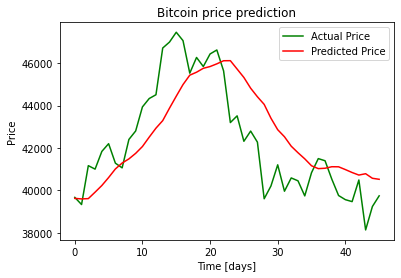

In [23]:
import matplotlib.pyplot as plt
from matplotlib import rc

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [27]:
model.save('C:/Users/nostr/OneDrive/Documents/DjangoProject/crypto/QuickBase/QuickBase-app/model')

INFO:tensorflow:Assets written to: C:/Users/nostr/OneDrive/Documents/DjangoProject/crypto/QuickBase/QuickBase-app\assets


INFO:tensorflow:Assets written to: C:/Users/nostr/OneDrive/Documents/DjangoProject/crypto/QuickBase/QuickBase-app\assets


import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import random
username = 'William'
email = 'nostrowilly99@gmail.com'
code = random.randrange(1000, 9999)
mail_content = '''
Bonjour ''' +username + '''

We received an unrecognized request to log in to your account from a new location in France.

If you did not try to log in from a new location in France just now, you should change your password immediately. Please double-check the URL to make sure that it is ftx.com, and not some other domain impersonating FTX.

Under no circumstances should you copy or share the link below.

If you did just log in from a new location in France, then using the device you just tried to log in from, please click the following link to log into your FTX account: 

''' +str(code) + '''

Merci de faire confiance à QuickBase.

--------------------------
QuickBase: https://quickbase-app.com
'''
#The mail addresses and password
sender_address = 'sup.quickbase.app@gmail.com'
sender_pass = 'momoleplusbo'
receiver_address = email
#Setup the MIME
message = MIMEMultipart()
message['From'] = sender_address
message['To'] = receiver_address
message['Subject'] = 'Your QuickBase verification code'   #The subject line
#The body and the attachments for the mail
message.attach(MIMEText(mail_content, 'plain'))
#Create SMTP session for sending the mail
session = smtplib.SMTP('smtp.gmail.com', 587) #use gmail with port
session.starttls() #enable security
session.login(sender_address, sender_pass) #login with mail_id and password
text = message.as_string()
session.sendmail(sender_address, receiver_address, text)
session.quit()